# This code imports functions from the finite element framework OpenSees and models a 2 DOF structure for the analysis of nonstructural component based on
Martinelli, E., & Faella, C. (2016). An Overview of the Current Code Provisions on the Seismic Response of Acceleration-Sensitive Non-Structural Components in Buildings. Applied Mechanics and Materials, 847, 273–280. https://doi.org/10.4028/www.scientific.net/amm.847.273

In [1]:
import openseespy.opensees as ops
import numpy as np 

def SDOF_response(file,dt_in,dt_ana,Tmax,m1,ma_m1,T1,Ta,R,fe,inelastic=False):
    ops.wipe()
    ops.model('basic', '-ndm', 1, '-ndf', 1)
    
    #setup variables
    w1 = 2*np.pi/T1
    wa = 2*np.pi/Ta
    zi = 0.05    
    ma = ma_m1*m1
    k1 = w1**2*m1
    ka = wa**2*ma
    fy = fe/R
    
    #analysis variables
    MATID1=1
    MATIDa=2
    ELEID1=5
    ELEIDa=6
    b=0.0    
    a0= 2*zi*(w1*wa)/(w1+wa)
    a1= 2*zi/(w1+wa)
    loadID = 4
    GMdirection = 1
    Nsteps = int(Tmax/dt_ana)
    Tol = 1.0e-8
    max_iter = 25
    gamma = 0.5 #Newmark gamma 
    beta = 0.25 #Newmark beta
    
    #create nodes 
    ops.node(1, 0.0)
    ops.node(2, 0.0,'-mass',m1)
    ops.node(3, 0.0,'-mass',ma)
    
    #set up boundary conditions 
    ops.fix(1,1)
    
    #define materials 
    if inelastic:
        ops.uniaxialMaterial('Steel01',MATID1,fy,k1,b)
        ops.uniaxialMaterial('Elastic',MATIDa,ka)
    else:
        ops.uniaxialMaterial('Elastic',MATID1,k1)
        ops.uniaxialMaterial('Elastic',MATIDa,ka)
    
    ops.element('zeroLength',ELEID1,1,2,'-mat',MATID1,'-dir',(1),'-doRayleigh',1)
    ops.element('zeroLength',ELEIDa,2,3,'-mat',MATIDa,'-dir',(1),'-doRayleigh',1)
    
    #define damping 
    ops.rayleigh(a0,a1,0.0,0.0)
    
    #define loading
    ops.timeSeries("Path",loadID,"-dt",dt_in,"-filePath",file,"-factor",9810.0)
    ops.pattern("UniformExcitation", loadID,GMdirection,'-accel',loadID)
    
    #start of analysis 

    # create SOE
    ops.system("ProfileSPD")

    # create DOF number
    ops.numberer("Plain")

    # create constraint handler
    ops.constraints("Plain")

    #create test type 
    ops.test("NormUnbalance",Tol,max_iter,0)

    #set algorithm type 
    ops.algorithm('NewtonLineSearch')

    #set integrator 
    ops.integrator("Newmark",gamma,beta)

    #set analysis type 
    ops.analysis("Transient")
    
    # perform analysis 
    #data = np.zeros((Nsteps+1,3))
    time = np.zeros(Nsteps+1)
    disp = np.zeros(Nsteps+1)
    acc = np.zeros(Nsteps+1)    
    for i in range(Nsteps):
        ops.analyze(1,dt_ana)
        #data[i+1,0] = getTime()
        #data[i+1,1] = nodeDisp(2,1)
        #data[i+1,2] = eleResponse(1,'forces')[0]
        time[i+1] = ops.getTime()
        disp[i+1] = ops.nodeDisp(2,1)
        acc[i+1] = ops.nodeAccel(3,1)
    return time, disp, acc

In [ ]:
First compute the elastic response and find out the elastic strength 

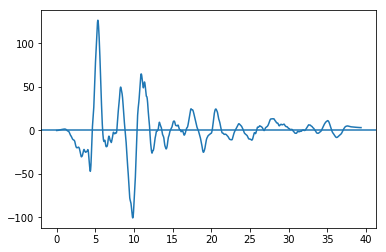

In [4]:
import matplotlib.pyplot as plt 
file = "D:\\Works\\DUDBC\\NBC-105\\groundmotion_data\\analysis\\IRPINIA_ITALY_00.txt"
dt_in = 0.0024
dt_ana = 0.0024
Tmax = 39.3408
m1 = 1000.0
ma_m1 = 0.01
T1 = 0.4
Ta = 0.04
R = 5
fe = 3.94
time, dispe, acce = SDOF_response(file,dt_in,dt_ana,Tmax,m1,ma_m1,T1,Ta,R,fe,inelastic=False)
fe = max(abs(dispe))/1000*(2*np.pi/T1)**2*m1
time, dispen, accen = SDOF_response(file,dt_in,dt_ana,Tmax,m1,ma_m1,T1,Ta,R,fe,inelastic=True)
plt.plot(time,dispen)
plt.axhline(y=0)

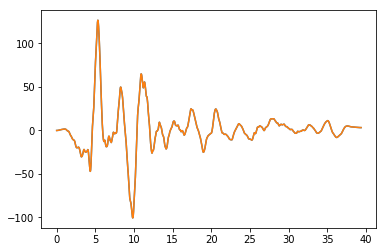

In [6]:
time2, dispe2, acce2 = SDOF_response(file,dt_in,dt_ana,Tmax,m1,0.001,T1,Ta,R,fe,inelastic=False)
fe2 = max(abs(dispe))/1000*(2*np.pi/T1)**2*m1
time2, dispen2, accen2 = SDOF_response(file,dt_in,dt_ana,Tmax,m1,0.001,T1,Ta,R,fe2,inelastic=True)
plt.plot(time,dispen,label="m1")
plt.plot(time2,dispen2,label="m2")

In [2]:
import numpy as np 
a = np.logspace(-4,0,20)



In [4]:
for values in a:
    print(values)

0.0001
0.0001623776739188721
0.00026366508987303583
0.00042813323987193956
0.0006951927961775605
0.0011288378916846883
0.0018329807108324356
0.002976351441631319
0.004832930238571752
0.007847599703514606
0.012742749857031334
0.0206913808111479
0.03359818286283781
0.05455594781168514
0.08858667904100823
0.14384498882876628
0.23357214690901212
0.3792690190732246
0.615848211066026
1.0
